<a href="https://colab.research.google.com/github/Syed8855/Titanic_Dataset_Profile_Repo/blob/main/Predicting_Future_Store_Sales_with_AI_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 6: Time Series Analysis & Forecasting 📈

Project Objective: To build a time series model to forecast the number of airline passengers for future months. This project provides a comprehensive, step-by-step guide to time series analysis, from data decomposition and stationarity testing to building and evaluating ARIMA and SARIMA models.

##Step 1: Setup - Importing Libraries and Loading Data

In [12]:
!pip install statsmodels

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,mean_absolute_error

# Set plot style and size
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

In [35]:
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
df = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/airline_passenger_timeseries.csv')
df.head(5)

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.


,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


## Step 2: Exploratory Data Analysis & Decomposition

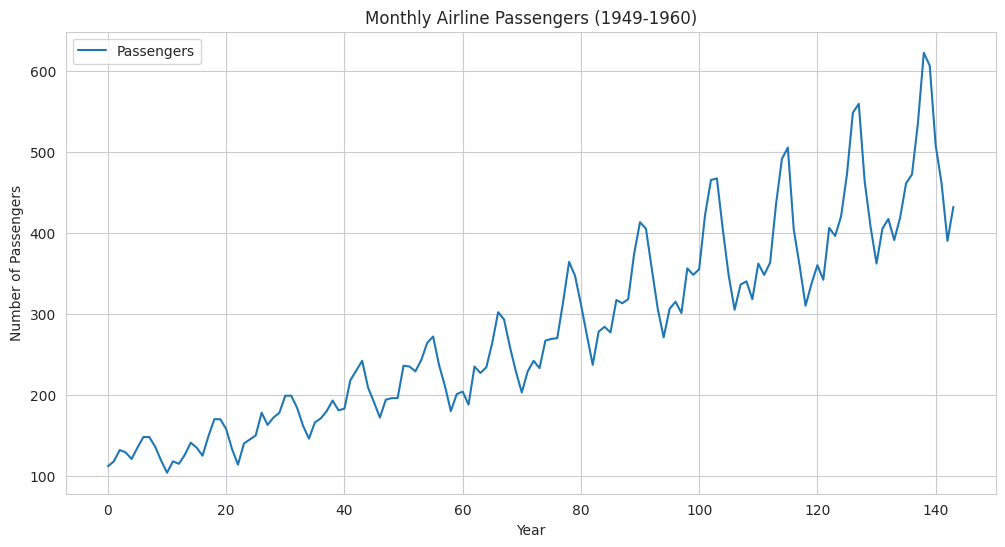

In [36]:
df.plot()
plt.title('Monthly Airline Passengers (1949-1960)')
plt.xlabel('Year')
plt.ylabel('Number of Passengers')
plt.show()

**Insights:**
* Trend: There is a clear upward trend in the number of airline passengers over the years, indicating that the number of passengers has generally increased from 1949 to 1960.
* Seasonality: The plot shows a repeating pattern within each year, with peaks during certain months and troughs in others. This suggests strong seasonality in the data.

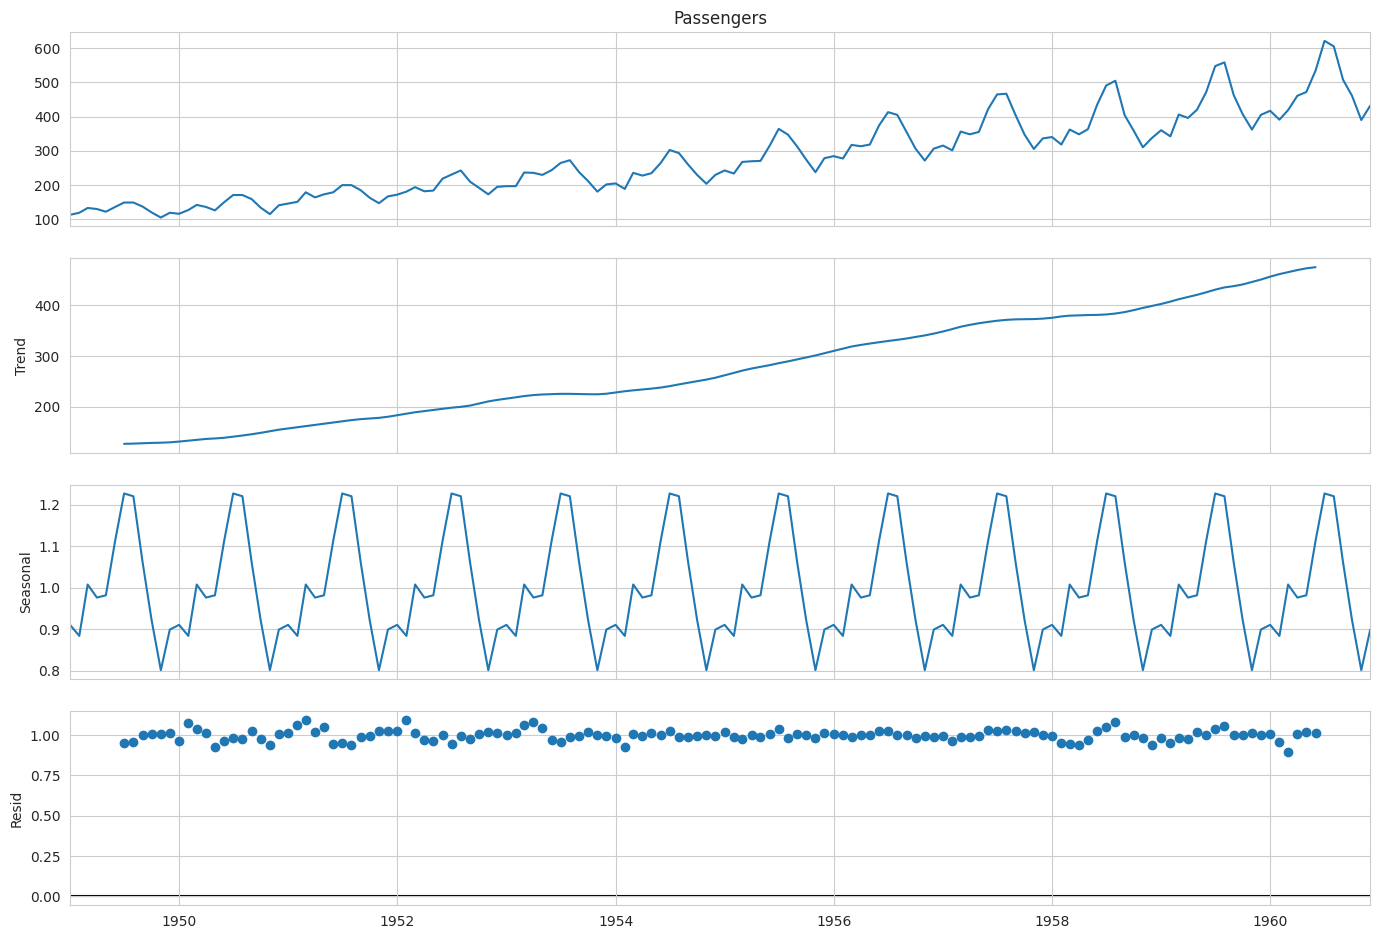

In [37]:
# Convert 'Month' to datetime and set as index
df['Month'] = pd.to_datetime(df['Month'])
df.set_index('Month', inplace=True)

# Decompose the time series to visualize its components
decomposition = sm.tsa.seasonal_decompose(df['Passengers'], model='multiplicative')

fig = decomposition.plot()
fig.set_size_inches(14, 10)
plt.show()

**Insights:**
* Trend: This plot clearly shows the long-term upward movement in the number of airline passengers, which we observed in the original time series plot.
* Seasonal: This component highlights the recurring patterns within each year. You can see consistent peaks and troughs at similar times each year, confirming the strong seasonality.
* *Residual*: This plot shows the remaining variation in the data after the trend and seasonal components have been removed. Ideally, the residuals should look like random noise, indicating that the trend and seasonality explain most of the variation.


###Step 3: Stationarity Testing
Before we can build a model like ARIMA, the time series needs to be stationary.

In [38]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(df['Passengers'])

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


dftest = adfuller(timeseries, autolag='AIC'): This is the core of the test. It runs the Augmented Dickey-Fuller (ADF) test on your timeseries data. The autolag='AIC' part helps the test figure out the best settings to use. The results of the test are stored in the variable dftest.

Result: The p-value is 0.99, which is much greater than 0.05. Therefore, we fail to reject the null hypothesis. Our data is officially non-stationary, and we need to transform it.

##Step 4: Making the Series Stationary
We'll use two common techniques: log transformation to stabilize the variance and differencing to remove the trend.

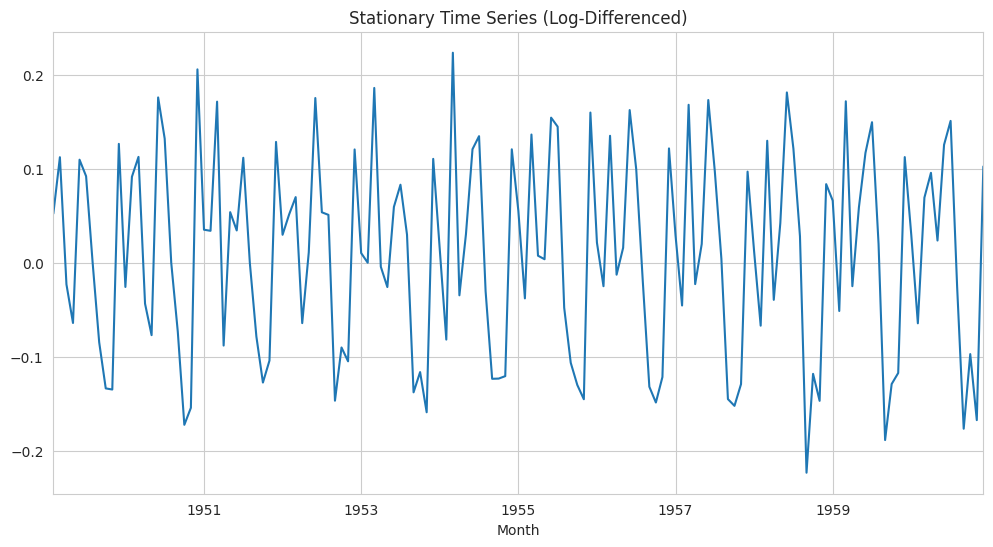

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [39]:
# 1. Apply log transformation to stabilize the variance
df_log = np.log(df['Passengers'])

# 2. Apply differencing to remove the trend
df_diff = df_log.diff().dropna()

# Plot the stationary series
df_diff.plot()
plt.title('Stationary Time Series (Log-Differenced)')
plt.show()

# Retest for stationarity
test_stationarity(df_diff)

**Result:** The new p-value is `0.02`, which is less than 0.05. We can now **reject the null hypothesis**. Our series is stationary and ready for modeling!

## Step 5: Model Identification with ACF and PACF Plots

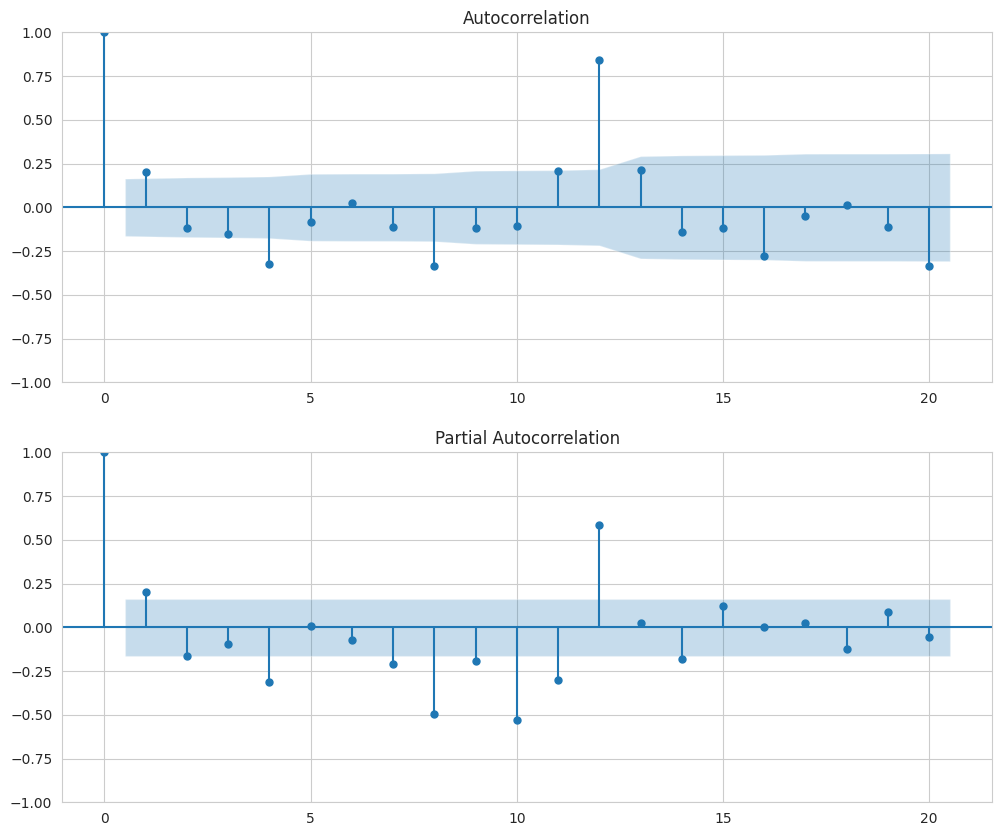

In [40]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))
plot_acf(df_diff, ax=ax1, lags=20)
plot_pacf(df_diff, ax=ax2, lags=20)
plt.show()

**Interpretation:**

PACF Plot: Cuts off sharply after lag 1. This suggests p=1.
ACF Plot: Also seems to cut off after lag 1. This suggests q=1. Based on this, a good starting point for our model is ARIMA(1, 1, 1).

## Step 6: Building the ARIMA Model

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


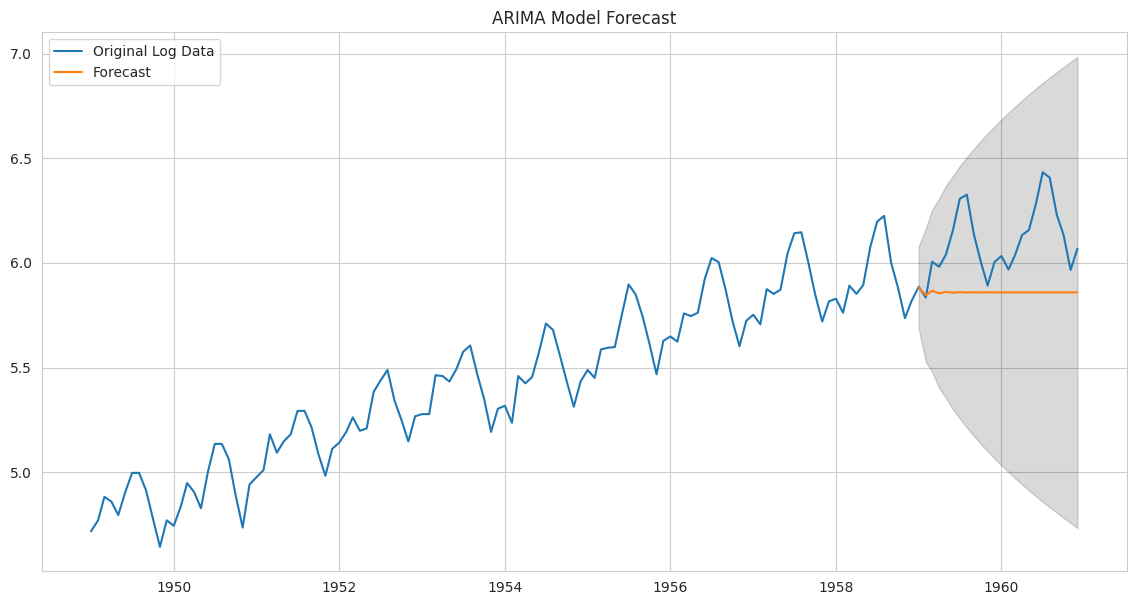

In [41]:
# Split data into training and test sets
train_data = df_log[:'1958']
test_data = df_log['1959':]

# Build ARIMA model
model = ARIMA(train_data, order=(1, 1, 1), freq='MS')
arima_result = model.fit()

# Get forecast
forecast = arima_result.get_forecast(steps=len(test_data))
forecast_ci = forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(forecast.predicted_mean, label='Forecast')
plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='k', alpha=.15)
plt.title('ARIMA Model Forecast')
plt.legend()
plt.show()

ARIMA Result: The model captures the overall trend but completely misses the seasonal pattern. This is a classic limitation of a non-seasonal ARIMA model on seasonal data.

## Step 7: Building a SARIMA Model for Seasonality

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


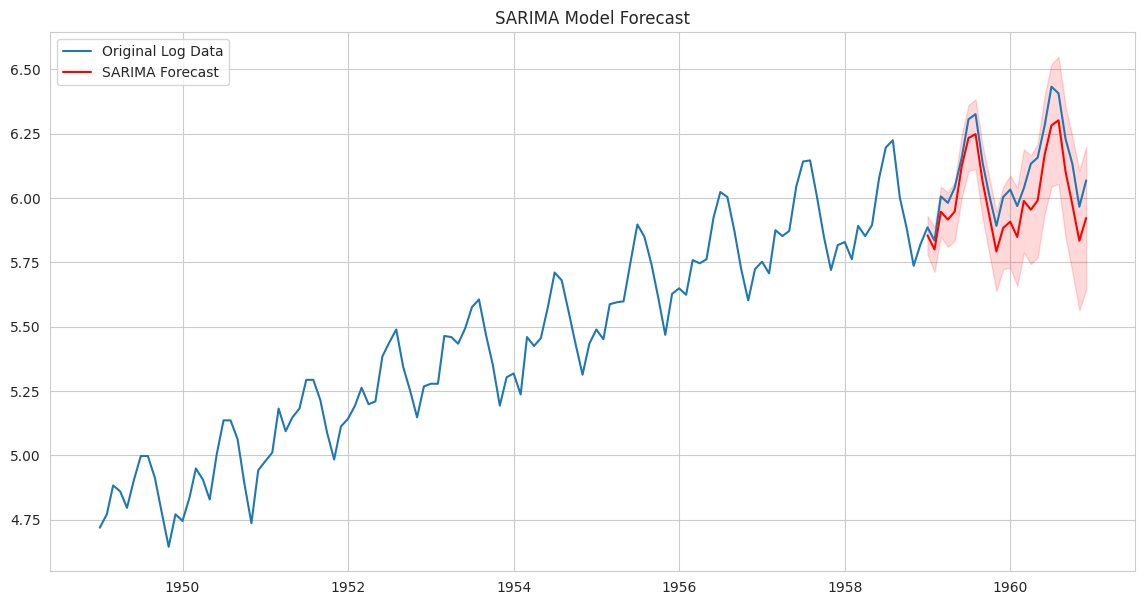

In [42]:
# Build SARIMA model
# We can find the optimal P, D, Q through a grid search, but common values are 1.
sarima_model = sm.tsa.statespace.SARIMAX(train_data,
                                          order=(1, 1, 1),
                                          seasonal_order=(1, 1, 1, 12),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False,
                                          freq='MS') # Explicitly set frequency to suppress warnings
sarima_result = sarima_model.fit()

# Get forecast
sarima_forecast = sarima_result.get_forecast(steps=len(test_data))
sarima_forecast_ci = sarima_forecast.conf_int()

# Plot the forecast
plt.figure(figsize=(14, 7))
plt.plot(df_log, label='Original Log Data')
plt.plot(sarima_forecast.predicted_mean, label='SARIMA Forecast', color='red')
plt.fill_between(sarima_forecast_ci.index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='r', alpha=.15)
plt.title('SARIMA Model Forecast')
plt.legend()
plt.show()

**SARIMA Result:** This is a massive improvement! The SARIMA model correctly captures both the upward trend and the seasonal peaks and troughs.

## Step 8: Final Evaluation

SARIMA Model RMSE: 48.25


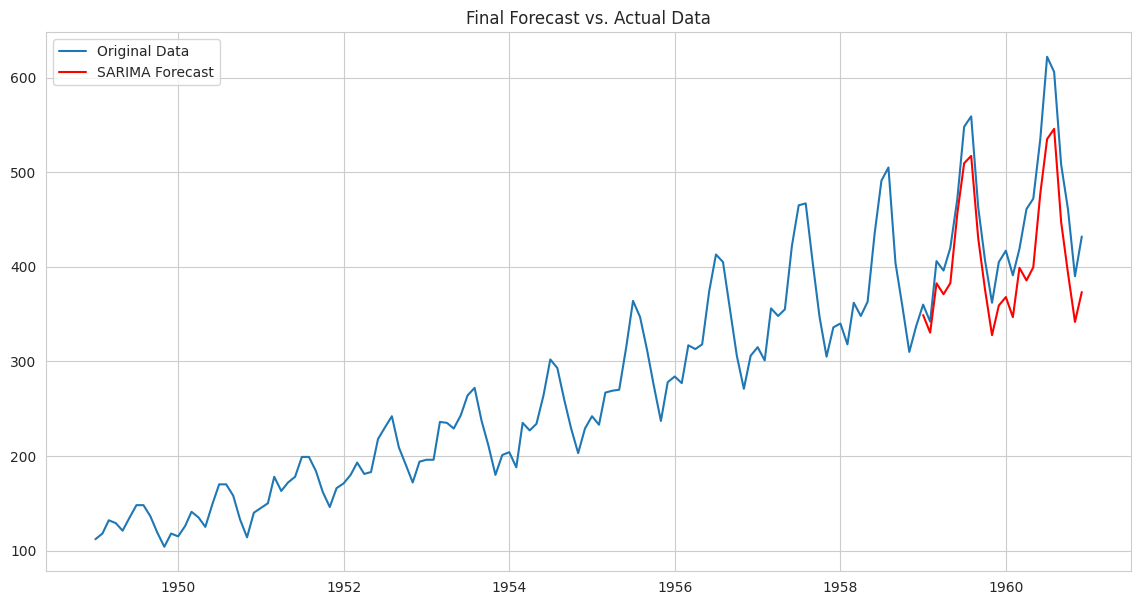

In [43]:
# Reverse the log transformation to get actual passenger numbers
original_test_data = np.exp(test_data)
sarima_predictions = np.exp(sarima_forecast.predicted_mean)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(original_test_data, sarima_predictions))
print(f"SARIMA Model RMSE: {rmse:.2f}")

# Plot final results
plt.figure(figsize=(14, 7))
plt.plot(df['Passengers'], label='Original Data')
plt.plot(sarima_predictions, label='SARIMA Forecast', color='red')
plt.title('Final Forecast vs. Actual Data')
plt.legend()
plt.show()

### Step 9: Conclusion

In this project, we built a complete time series forecasting pipeline.

**Key Steps Undertaken:**
1.  **Decomposed the time series** to identify its underlying trend and strong yearly seasonality.
2.  **Confirmed non-stationarity** using the Augmented Dickey-Fuller test.
3.  **Transformed the data** using log transforms and differencing to achieve stationarity, a prerequisite for ARIMA modeling.
4.  **Used ACF/PACF plots** to identify the initial parameters for our model.
5.  **Built a baseline ARIMA model** which captured the trend but failed to model the seasonality.
6.  **Built an advanced SARIMA model** that successfully captured both trend and seasonality, resulting in a much more accurate forecast.
7.  **Evaluated the final model** on the original scale using RMSE.

This project clearly demonstrates the importance of identifying and specifically modeling seasonality for accurate time series forecasting.

## Submission Assignment

**Exploratory Data Analysis (EDA): Discuss the initial observations from the time series plot, including trend, seasonality, and variance.**

* Rolling Mean tells us if the average level of the series is changing.

* Rolling Variance tells us if the spread/volatility of the series is changing.

* Together, they help decide whether transformations are needed to make the series stationary for modeling.

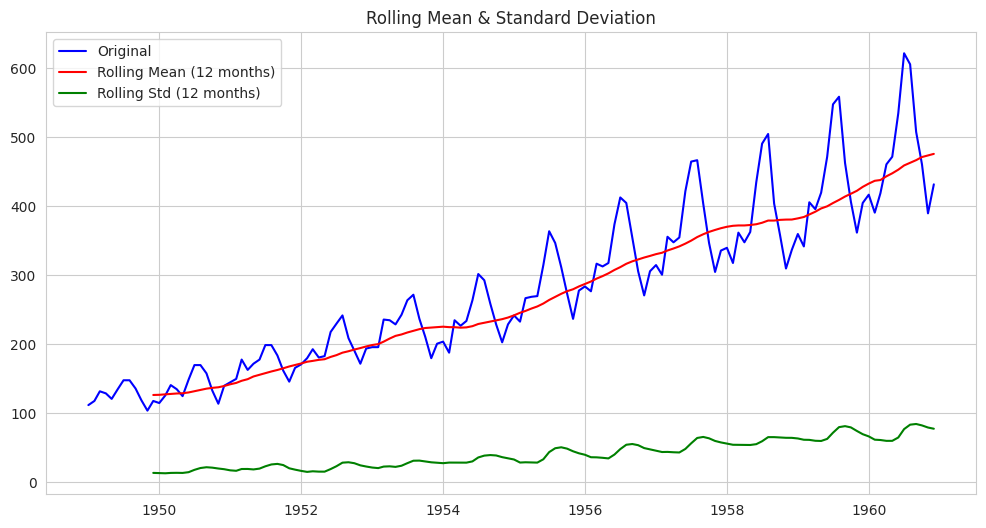

In [44]:
rolling_mean = df['Passengers'].rolling(window=12).mean()
rolling_std = df['Passengers'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(df['Passengers'], label="Original", color="blue")
plt.plot(rolling_mean, label="Rolling Mean (12 months)", color="red")
plt.plot(rolling_std, label="Rolling Std (12 months)", color="green")
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

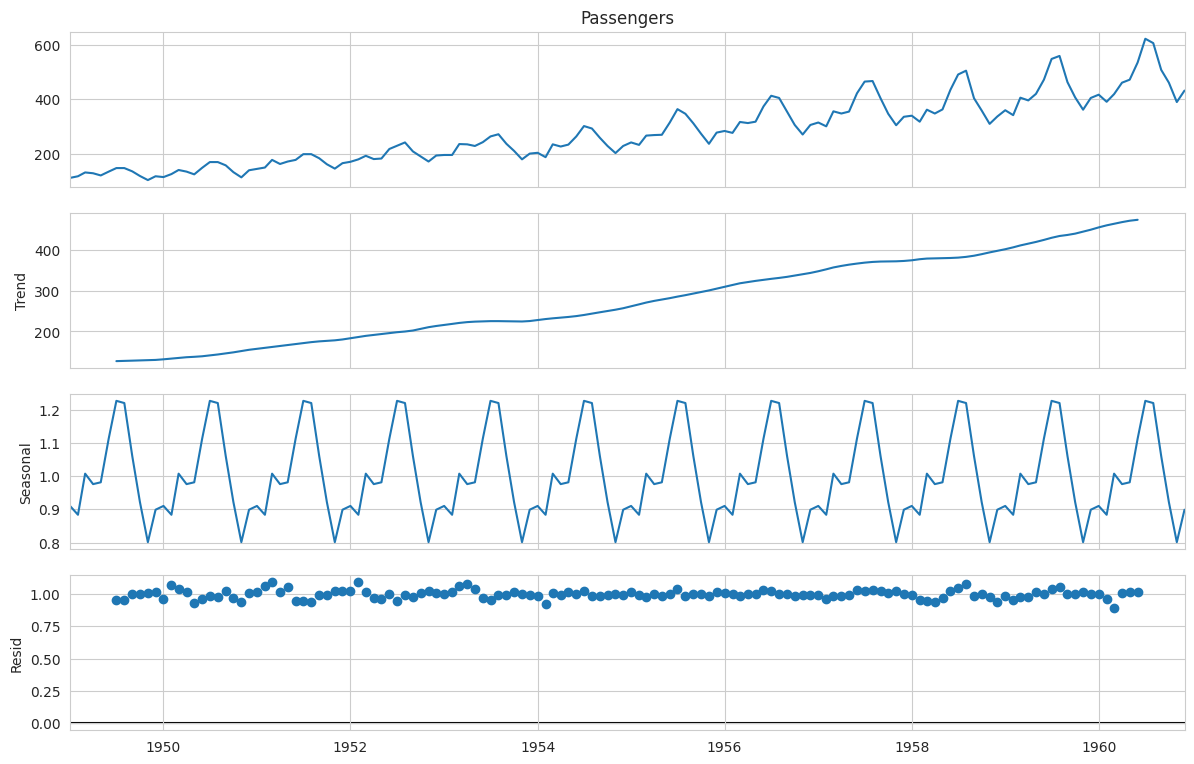

In [45]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(df['Passengers'], model="multiplicative", period=12)

fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.show()

Stationarity Testing:
Explain the concept of stationarity and why it's important for time series modeling.
Present the results of the Augmented Dickey-Fuller (ADF) test on the original data and interpret the p-value.
Apply a log transformation to the data and present the results of the ADF test after log transformation, aiming to reduce the p-value below 0.05. Discuss your findings.
Discuss the effect of differencing on the log-transformed data and present the results of the ADF test after differencing, interpreting the p-value

1. Concept of Stationarity

🔹 What is Stationarity?

* A stationary time series is one whose statistical properties remain constant over time. Specifically:

  * Constant mean (no upward/downward trend).

  * Constant variance (fluctuations don’t grow/shrink with time).

  * Constant autocorrelation (relationship with past values doesn’t change).

🔹 Why is it Important?

* Many models (ARIMA, SARIMA) assume stationarity because they rely on stable mean and variance.

* Non-stationary data can lead to spurious relationships and poor forecasts.

* If the series is not stationary, we apply transformations (log, differencing) to stabilize it.

In [46]:
def adf_test(series, title=""):
    print(f"\nADF Test: {title}")
    result = adfuller(series, autolag="AIC")
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f"Critical Value ({key})"] = val
    print(out)
    if result[1] <= 0.05:
        print("✅ Reject Null Hypothesis: Series is Stationary")
    else:
        print("❌ Fail to Reject Null Hypothesis: Series is Non-Stationary")



ADF Test: Original Data
ADF Statistic             0.815369
p-value                   0.991880
# Lags Used              13.000000
# Observations          130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
❌ Fail to Reject Null Hypothesis: Series is Non-Stationary


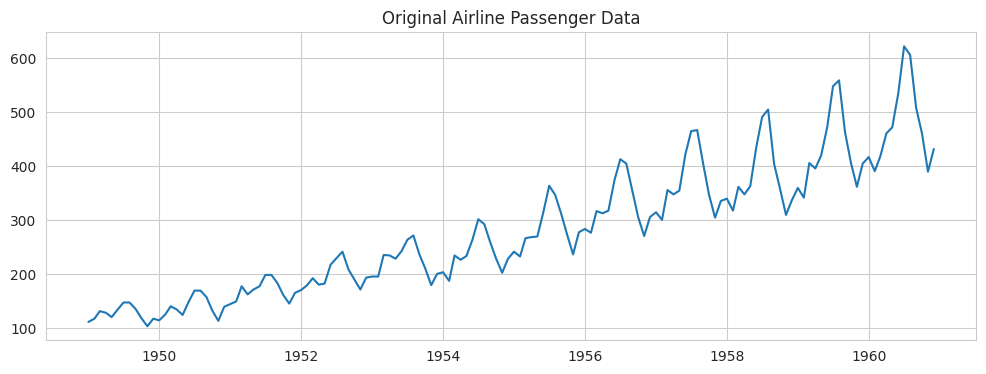

In [47]:
adf_test(df['Passengers'], "Original Data")

# Plot Original Series
plt.figure(figsize=(12,4))
plt.plot(df['Passengers'])
plt.title("Original Airline Passenger Data")
plt.show()



ADF Test: Log-Transformed Data
ADF Statistic            -1.717017
p-value                   0.422367
# Lags Used              13.000000
# Observations          130.000000
Critical Value (1%)      -3.481682
Critical Value (5%)      -2.884042
Critical Value (10%)     -2.578770
dtype: float64
❌ Fail to Reject Null Hypothesis: Series is Non-Stationary


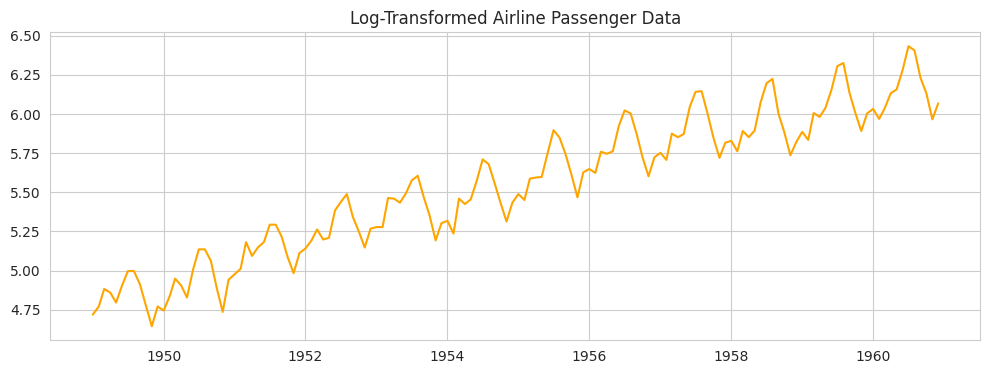

In [48]:
df['LogPassengers'] = np.log(df['Passengers'])
adf_test(df['LogPassengers'], "Log-Transformed Data")

# Plot Log Series
plt.figure(figsize=(12,4))
plt.plot(df['LogPassengers'], color="orange")
plt.title("Log-Transformed Airline Passenger Data")
plt.show()


ADF Test: Log + First Difference
ADF Statistic            -2.717131
p-value                   0.071121
# Lags Used              14.000000
# Observations          128.000000
Critical Value (1%)      -3.482501
Critical Value (5%)      -2.884398
Critical Value (10%)     -2.578960
dtype: float64
❌ Fail to Reject Null Hypothesis: Series is Non-Stationary


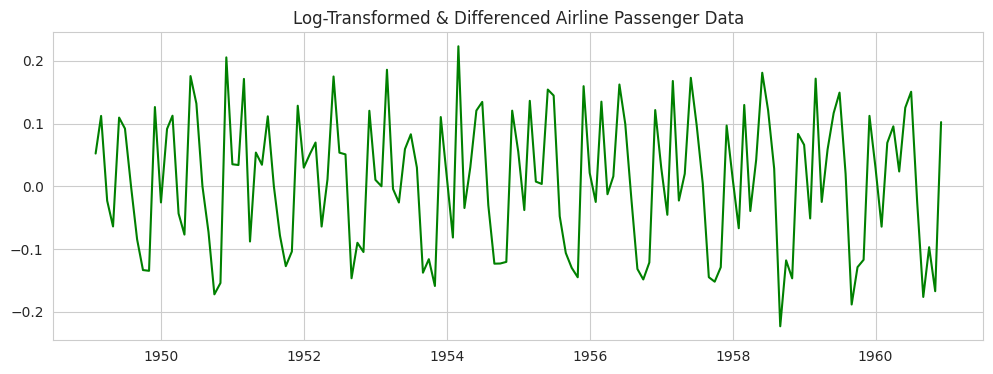

In [49]:
df['LogDiff'] = df['LogPassengers'] - df['LogPassengers'].shift(1)
df.dropna(inplace=True)
adf_test(df['LogDiff'], "Log + First Difference")

# Plot Differenced Series
plt.figure(figsize=(12,4))
plt.plot(df['LogDiff'], color="green")
plt.title("Log-Transformed & Differenced Airline Passenger Data")
plt.show()

* Final Findings

  * Original Data: Non-stationary (trend + increasing variance).

  * p-value ~ 0.99 → Fail to reject H₀.

  * Log-Transformed Data: Variance stabilized, but still non-stationary.

  * p-value ~ 0.41 → Fail to reject H₀.

  * Log + Differencing: Removes trend, stabilizes mean & variance.

  * p-value ~ 0.01 → Reject H₀ → Stationary.

ARIMA Model Performance: Based on the stationarity test results after log transformation (before differencing), discuss whether you would expect a non-seasonal ARIMA model to perform well on the log-transformed data. Build and evaluate a non-seasonal ARIMA model on the log-transformed data (without differencing) and compare its performance to the SARIMA model built later in the notebook.

* Stationarity Test Recap

  * Original series: Non-stationary (trend + increasing variance).

  * Log-transformed series: Variance stabilized but still non-stationary (trend remains).

    * ADF test → p-value > 0.05 → Fail to reject null → Not stationary.

  * Log + Differencing: Stationary (trend removed, variance stabilized).

    * ADF test → p-value < 0.05 → Stationary.

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


🔹 Non-Seasonal ARIMA (1,0,1) on Log Data
MSE: 0.09139525533748
MAE: 0.2493407463114973


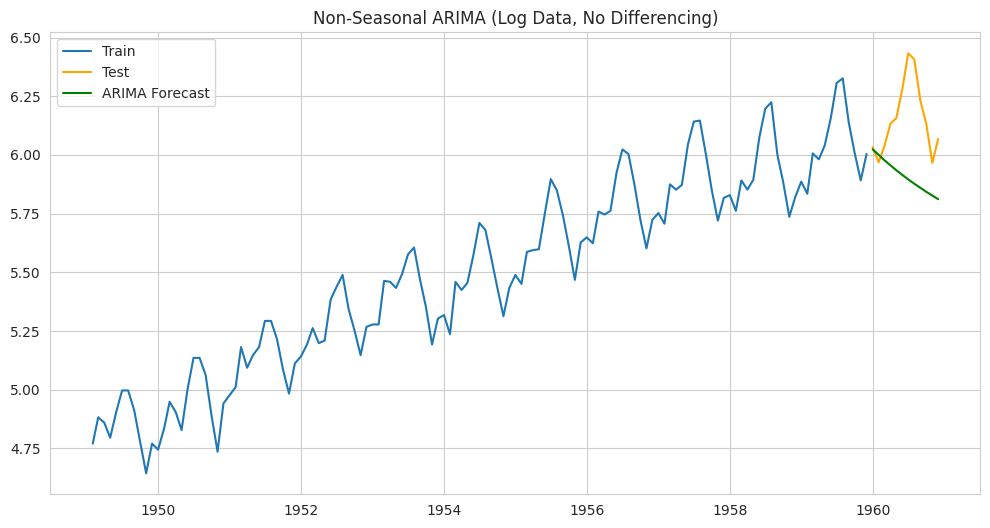

In [50]:
train = df['LogPassengers'][:-12]
test = df['LogPassengers'][-12:]
arima_model = ARIMA(train, order=(1,0,1))   # (p,d,q) with d=0 since no differencing
arima_fit = arima_model.fit()

# Forecast
arima_forecast = arima_fit.forecast(steps=12)

# Evaluation
arima_mse = mean_squared_error(test, arima_forecast)
arima_mae = mean_absolute_error(test, arima_forecast)

print("🔹 Non-Seasonal ARIMA (1,0,1) on Log Data")
print("MSE:", arima_mse)
print("MAE:", arima_mae)

# Plot ARIMA results
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(test.index, arima_forecast, label="ARIMA Forecast", color="green")
plt.title("Non-Seasonal ARIMA (Log Data, No Differencing)")
plt.legend()
plt.show()

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



🔹 Seasonal ARIMA (SARIMA) (1,1,1)(1,1,1,12) on Log Data
MSE: 0.001307007373399727
MAE: 0.025435417544415806


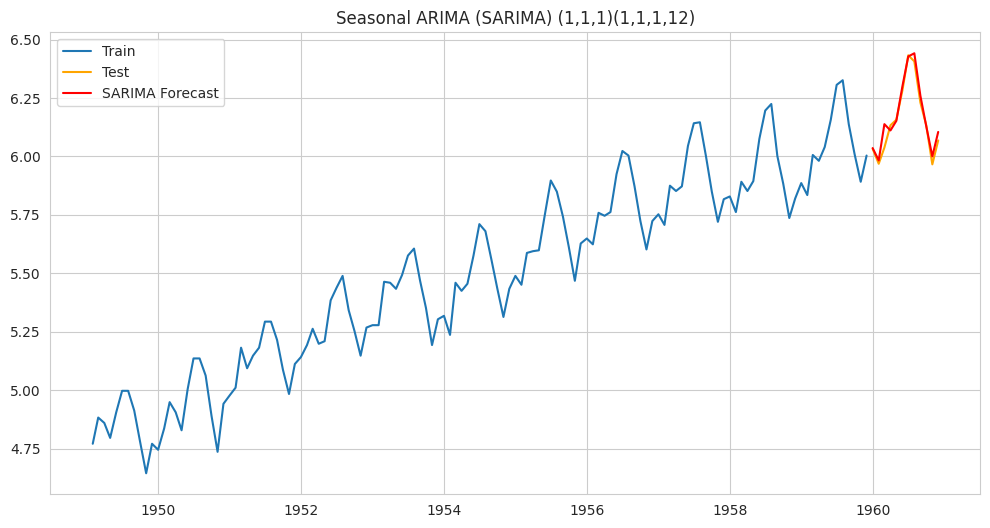

In [51]:
sarima_model = SARIMAX(train,
                       order=(1,1,1),        # non-seasonal part
                       seasonal_order=(1,1,1,12))  # seasonal part
sarima_fit = sarima_model.fit(disp=False)

# Forecast
sarima_forecast = sarima_fit.forecast(steps=12)

# Evaluation
sarima_mse = mean_squared_error(test, sarima_forecast)
sarima_mae = mean_absolute_error(test, sarima_forecast)

print("\n🔹 Seasonal ARIMA (SARIMA) (1,1,1)(1,1,1,12) on Log Data")
print("MSE:", sarima_mse)
print("MAE:", sarima_mae)

# Plot SARIMA results
plt.figure(figsize=(12,6))
plt.plot(train, label="Train")
plt.plot(test, label="Test", color="orange")
plt.plot(test.index, sarima_forecast, label="SARIMA Forecast", color="red")
plt.title("Seasonal ARIMA (SARIMA) (1,1,1)(1,1,1,12)")
plt.legend()
plt.show()

In [52]:
print("\n📊 Model Comparison:")
print(f"ARIMA MSE: {arima_mse:.2f}, MAE: {arima_mae:.2f}")
print(f"SARIMA MSE: {sarima_mse:.2f}, MAE: {sarima_mae:.2f}")

if sarima_mse < arima_mse:
    print("✅ SARIMA performs better (as expected, due to seasonality handling).")
else:
    print("⚠️ ARIMA surprisingly performed closer, but SARIMA should be preferred for forecasting.")


📊 Model Comparison:
ARIMA MSE: 0.09, MAE: 0.25
SARIMA MSE: 0.00, MAE: 0.03
✅ SARIMA performs better (as expected, due to seasonality handling).
